## パッケージ

In [58]:
# 必要なライブラリのimport
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
from pathlib import Path

# matplotlibの日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [2]:
# データフレームの特徴を自動的に作ってくれる pandas-profiling を利用する
from pandas_profiling import ProfileReport

# report = ProfileReport(hogehoge)
# report.to_file(os.path.join(OUTPUT_DIR, "report.html"))

# 今回のコンペについて
今回は `Google Cloud & NCAA ML Competition 2018-Men's` というコンペに参加します

ページリンクは以下です。\
[Google Cloud & NCAA ML Competition 2018-Men's Kaggle Page](https://www.kaggle.com/competitions/mens-machine-learning-competition-2018/data)


今回のコンペの問題設定は NCAA男子バスケットボールトーナメントの対戦予測確率を提出することです。\
Kaggleページの `Data`　に記載されている `What to predict` を参照すると以下の通り書かれています
* Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA tournaments (2014-2017).
* Stage 2 - You should submit predicted probabilities for every possible matchup before the 2018 tournament begins.
* Refer to the Timeline page for specific dates. In both stages, the sample submission will tell you which games to predict.

これを訳すと以下の通りです
* ~~Stage 1 - 過去4回のNCAAトーナメント(2014-2017)のすべての対戦の予測確率を提出する必要がある。~~  ＊過去コンペなのでこのステージは必要ありません
* Stage 2 - 2018 年のトーナメントが始まる前に、(可能性のある)すべての対戦の予測確率を提出する必要がある。
* 具体的な日程については、タイムラインページを参照すること。どちらのステージでも、`sample submission` を見れば、どのゲームの予測をするのかわかる。

\
KaggleページにもWikipediaで確認した方がよいと書かれているのでWikipediaを貼っておきます

[NCAA男子バスケットボールトーナメント（日本語版）](https://ja.wikipedia.org/wiki/NCAA%E7%94%B7%E5%AD%90%E3%83%90%E3%82%B9%E3%82%B1%E3%83%83%E3%83%88%E3%83%9C%E3%83%BC%E3%83%AB%E3%83%88%E3%83%BC%E3%83%8A%E3%83%A1%E3%83%B3%E3%83%88)

[NCAA Division I Men's Basketball Tournament (ENG)](https://en.wikipedia.org/wiki/NCAA_Division_I_Men%27s_Basketball_Tournament)


# 評価方法について
評価方法は <b>LogLoss(=Logarithmic Loss)</b>というものを採用しています。

* 分類モデルの性能を測る指標。(このLog lossへの)入力は <b>0~1の確率の値</b>をとります。
* この値を最小化するのが目的です。
* 予測確率が外れているほど高いペナルティが与えられ、低い程よい指標です。
* Log Lossは実際のラベルからどのくらい違っていたのかを考慮できます（惜しかった、などが測れる）。

[機械学習でLog Lossとは何か](https://qiita.com/exp/items/1c6c9a3fae2d97bfa0c7)

[機械学習の評価関数（二値分類用）の基礎](https://atmarkit.itmedia.co.jp/ait/articles/2010/27/news020.html#binaryclassify)

[機械学習の評価関数（二値分類／多クラス分類用）の応用](https://atmarkit.itmedia.co.jp/ait/articles/2103/04/news023.html#binaryclassify)

# データ読み込み

[2nd stageにかけてデータがupdated](https://www.kaggle.com/competitions/mens-machine-learning-competition-2018/discussion/51133) されているので、そちらに注意してください

これは完全に好みですが、input_dataは `data` フォルダを用意してそこに保管し、可視化レポートや一部サンプルデータ等のoutput_dataは `outputs` フォルダに保管しておきたいので以下を実行します


In [3]:
# input_dir（input directory） を作ります
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# # csvファイルを `data` ディレクトリ（=フォルダー） に移動させます
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*'):
#     if os.path.isdir(f):
#         unique_dir_names.append(f)
#     elif (os.path.relpath(os.path.splitext(f)[0]) == 'SampleSubmissionStage2') or (os.path.relpath(os.path.splitext(f)[0]) == 'SampleSubmissionStage1'):
#         unique_dir_names.append(f)

# for dir in list(set(unique_dir_names)):
#     print(f'moved dir or file: {dir}')
#     shutil.move(f'{dir}', f'{INPUT_DIR}')


# output_dir(output directory) を作ります
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


## Data Section 1 - The Basics

このセクションでは、簡単な予測モデルを構築し、予測を提出するために必要な基本的データを表しています。

<b>Teams</b>

このファイルは、データセットに存在する様々な大学のチームを識別します。\
試合リストは、両チームがDivision-Iのチームである対戦のみであるため、すべてのシーズンのすべてのチームの試合が表示されるわけではありません。\
現在Division-Iに所属しているのは351チーム、チームリスト全体では364チームです (毎年、Division-Iプログラムになるチームもあれば、Division-Iプログラムでなくなるチームもあるかもしれません)。各チームは4桁のID番号を持っています。

In [4]:
teams = pd.read_csv('data/DataFiles/Teams.csv')
teams

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018
...,...,...,...,...
359,1460,Wright St,1988,2018
360,1461,Wyoming,1985,2018
361,1462,Xavier,1985,2018
362,1463,Yale,1985,2018


<b>Seasons</b>

> 2nd stageにかけて updated されたので、そちらを読み込みます

* Season - トーナメントが行われた年を示します。
* DayZero - そのシーズン中のdaynum=0に対応する日付を示しています。すべての試合の日付は、`決勝トーナメントの優勝決定戦がdaynum=154`になるように、共通の尺度で整列されています。逆算すると、`全米準決勝は常にdaynum=152`、「`プレイイン」ゲームは134/135日目`、`セレクションサンデーは132日目`、といった具合になります。
* RegionW, RegionX, Region Y, Region Z - 慣例により、決勝トーナメントの4つの地域は、常にW、X、Y、Zと名付けられます。アルファベット順で最初に来る地域は、地域Wとなり、準決勝で地域Wと対戦する地域は、地域Xとなります。例えば、2012年のトーナメントでは、`East, Midwest, South, West` の4つの地域がありましたが、この場合、`East = W, Midwest = X, South = Y, West = Z` となります。ファイナル4の全米準決勝の組み合わせは、4つの第1シードの総合順位に左右されるため、最終的なW/X/Y/Zの指定は、セレクションサンデーまでわかりません。

In [5]:
seasons = pd.read_csv('data/Stage2UpdatedDataFiles/Seasons.csv')
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


<b>NCAATourneySeeds</b>

各 NCAA トーナメントにおける全チームのシードの過去の全シーズンのデータについて含んでいます。プレイインゲームの有無とその数に応じて、各年で64～68行になります。近年は、合計68チームの構成に落ち着き、8回のプレーインゲームにより、64チームの最終フィールドが第1週の木曜日にラウンド1を迎えます。2018年3月11日のセレクションサンデーまで、各トーナメント出場チームのシードはもちろん、どの68チームになるのかも正確にはわかりません。

> 2nd stageにかけて updated されたので、そちらを読み込みます

* Season - そのトーナメントが行われた年
* Seed - 3~4文字のシードの識別子。
  * 最初の文字は W, X, Y, Z でチームのいた地域を示す
  * 次の2桁は 01, 02, ~, 16 で地域内のシードを知ることができる。
  * プレーインゲームで対戦するチームは、シードをさらに区別するために4文字目（a or b） を追加します。

In [33]:
# NCAA TourneySeeds
tourneyseeds = pd.read_csv('data/Stage2UpdatedDataFiles/NCAATourneySeeds.csv')
tourneyseeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2213,2018,Z13,1422
2214,2018,Z14,1285
2215,2018,Z15,1252
2216,2018,Z16a,1300


<b>RegularSeasonCompactResults</b>

1985年シーズン（NCAAが64チームトーナメントを開催した最初の年）から始まる、多くのシーズンの履歴データのゲームごとの結果を示すデータです。

各シーズンについて、このファイルは日数0から132までに行われたすべてのゲームを含んでいます。\
ここで重要なのは、「レギュラーシーズン」の試合は単純に日数132またはそれ以前に行われたすべての試合と定義されていることです（日数132は選抜日曜日で、選抜日曜日の早朝に実際に行われるカンファレンストーナメント決勝戦が常にいくつか存在します）。

したがって、プレシーズントーナメント、ノンカンファレンスゲーム、レギュラーカンファレンスゲーム、カンファレンストーナメントゲーム、その他に関わらず、`セレクションサンデー以前に行われたゲームはここに表示される`ことになります

> 2nd stageにかけて updated されたので、そちらを読み込みます

* Season - Seasons.csvの関連エントリーの年です（決勝トーナメントが開催される年）。
* DayNum - この整数は常に0から132の範囲にあり、試合が何日に行われたかを示しています。Seasons.csv ファイル内の「DayZero」日付からのオフセットを表します。
  * 例えば、このファイルの最初のゲームは、DayNum=20です。Seasons.csv ファイルから、この年のデイゼロが1984/10/29であることを考えると、最初の試合は20日後、つまり1984/11/18に行われたことを意味します。ある日付に複数の試合を行ったチームは存在しないので、この事実を利用することで、（SeasonとDayNumとWTeamIDを組み合わせた）ユニークなキーを作ることができます。この一意性を実現するために、ある試合の日付を調整する必要がありました。2008年3月、SECのポストシーズン・トーナメントは、1試合（Georgia-Kentucky）を翌日に変更しなければならなかったので、Georgiaは実際には同じ日に2試合行わなければならなかったそうです。しかしデータの一意性を強化するため、ジョージア-ケンタッキー戦の試合日を、元の予定日に戻しているそうです。
  
* WTeamID - 「Teams.csv」ファイルに記載されている、試合に勝ったチームのID番号を識別するものです。試合がホームチームかビジターチームか、あるいは中立地の試合であるかにかかわらず、「WTeamID」は常に勝利したチームを識別します。
* WScore - 勝利したチームが獲得した得点数を表します。
* LTeamID - 試合に負けたチームのID番号です。
* LScore - 負けたチームの得点数を識別します。したがってすべてのゲームについて、WScoreがLScoreより大きいです
* WLoc - 勝利チームの「場所」を特定します。勝利したチームがホームチームの場合、この値は "H "になります。勝利したチームがビジターチームであった場合、この値は "A "となります。もし中立のコートで行われた場合は、この値は「N」となります。
  * 一方のチームのホームコートに近かったり、トーナメント中にそのチームのコートで行われたりして、その場所を中立とみなすべきかどうかが不明な場合もありますが、今回の判断では、Kenneth Masseyのデータをそのまま使用し、「@」記号を勝利チーム、敗北チーム、またはどちらのチームにも表示されないようにしています。この要因をより詳細に調査したい場合は、データセクション3を参照してください。データセクション3には、中立地とみなされるかどうかにかかわらず、各試合が行われた都市が記載されています。

* NumOT - 試合の延長戦の回数を表し、0以上の整数値です。

In [7]:
reg_game_compact = pd.read_csv('data/Stage2UpdatedDataFiles/RegularSeasonCompactResults.csv')
reg_game_compact

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
156084,2018,132,1153,56,1222,55,N,0
156085,2018,132,1172,58,1348,57,N,0
156086,2018,132,1209,74,1426,61,N,0
156087,2018,132,1246,77,1397,72,N,0


<b>NCAATourneyCompactResults</b>

全シーズンのNCAAトーナメントの結果をまとめたものです。

`RegularSeasonCompactResults` とデータ形式は同一です。\
これらのゲームには、プレイインゲームがあった年のプレイインゲーム（常に134日目/135日目に発生）も含まれていることに注意してください。\
したがって、各シーズンには、プレイインゲームがいくつあったかによって、63から67のゲームがリストアップされています。


NCAAトーナメントのスケジュールは一貫しているため、正確なDayNumによって、実際にどのラウンドの試合であったかがわかります。 

* DayNum=134または135（火/水） - トーナメント出場チームを最終64チームに絞り込むためのプレイインゲーム
* DayNum=136または137（木/金） - ラウンド1、64チームから32チームへのトーナメント参加。
* DayNum=138または139（土/日） - トーナメント出場チームを32チームから16チームにするためのラウンド2。
* DayNum=143または144（木/金） - ラウンド3、別名「Sweet Sixteen」、トーナメント参加チームを16チームから8チームに変更する。
* DayNum=145または146（土/日） - ラウンド4（別名「エリート8」または「地域決勝」）。
* DayNum=152（土） - ラウンド5（ファイナルフォーまたはナショナルセミファイナル）。
* DayNum=154（月）- 第6戦（別名「全米決勝」または「全米選手権」）：トーナメント出場チームが2チームから1チームになる。


In [8]:
tourney_compact = pd.read_csv('data/DataFiles/NCAATourneyCompactResults.csv')
tourney_compact

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2112,2017,146,1314,75,1246,73,N,0
2113,2017,146,1376,77,1196,70,N,0
2114,2017,152,1211,77,1376,73,N,0
2115,2017,152,1314,77,1332,76,N,0


<b>SampleSubmissionStage1, SampleSubmissionStage2</b>

このファイルは、ステージ1の提出ファイル形式を示したものです。samplesubmissionでは可能性のある各対戦について50%の勝率を予測しています。\
提出ファイルは、1年以上のトーナメントチーム間のすべての可能な対戦をリストアップします。

 ~~ステージ1では、過去4回のNCAAトーナメント（シーズン2014、2015、2016、2017）の可能性のあるすべての対戦について予測するよう求められます。~~ (＊過去コンペなのでこれは不必要です)

ステージ2では、現在のNCAAトーナメント（シーズン2018）から、可能性のあるすべての対戦の予想をします。\
トーナメントに出場するチームが68チームある場合、その年の予測しないといけない試合数は 68×67/2=2278（どのチームが対戦するかは不明なので、全チームがその他全チームと試合する場合の予測を計算する必要があります）となりますので、ステージ1の提出ファイルには2278×4(年分)=9112のデータ行が含まれることになります。


* ID - これはSSSS_XXXX_YYYYという形式の14文字の文字列で、SSSSは4桁のシーズン番号、XXXXは下位IDチームの4桁のチームID、YYYYは上位IDチームの4桁のチームIDを表しています。
* Pred - IDフィールドで特定された最初のチームの予測勝率が含まれます。

例1: もし、2012年のトーナメントで デューク (TeamID=1181) 対 アリゾナ (TeamID=1112) をデュークが勝つ確率53%、アリゾナが勝つ確率47%と予測したい場合、アリゾナの方がIDが小さいので、アリゾナが最初に表示され、勝率はアリゾナの視点（47%）で表現されます。

2012_1112_1181,0.47

In [9]:
samplesub_1 = pd.read_csv('data/SampleSubmissionStage1.csv')
samplesub_2 = pd.read_csv('data/SampleSubmissionStage2.csv')
samplesub_2

,ID,Pred
0,2018_1104_1112,0.5000
1,2018_1104_1113,0.5000
2,2018_1104_1116,0.5000
3,2018_1104_1120,0.5000
4,2018_1104_1137,0.5000
...,...,...
2273,2018_1452_1460,0.5000
2274,2018_1452_1462,0.5000
2275,2018_1455_1460,0.5000
2276,2018_1455_1462,0.5000


## Data Section 2 - Team Box Scores

このセクションでは、2002-03シーズン以降のレギュラーシーズン、カンファレンストーナメント、NCAAトーナメントの全試合の、チームレベルでのゲームごとのスタッツ（フリースロー試投数、ディフェンスリバウンド、ターンオーバー数など）を表しています。

<b>チームボックススコア</b>

チームボックススコアは、「Compact Results」ファイルではなく、「Detailed Results」ファイルで見れます。しかし、`compact results` と `Detailed Results` の関係は深いです

最初の8列（Season、DayNum、WTeamID、WScore、LTeamID、LScore、WLoc、NumOT）がCompact Resultsファイルと全く同じです。

「W」= 買ったチーム, 「L」= 負けたチーム

* WFGM - フィールドゴール数(勝利チーム)
* WFGA - フィールドゴールの試行回数（勝利チーム）
* WFGM3-成功したスリーポインターゲーム（勝利チーム）
* WFGA3 - 試みられたスリーポイント（勝利チームによるもの）
* WFTM - フリースロー（勝利チーム）
* WFTA - フリースローの試投数（勝利チーム）
* WOR - オフェンスリバウンド(勝利チームが獲得)
* WDR - ディフェンスリバウンド(勝利チームが獲得)
* WAst - アシスト(勝利チーム)
* WTO - （勝利チームが）犯したターンオーバー
* WStl - スティール（勝利チームが達成したもの）
* WBlk - ブロック（勝利チームが達成したもの）
* WPF - （勝利チームが）犯したパーソナルファウル

(そして、負けたチームの立場から見た同じスタッツのセット。LFGMは負けたチームが決めたフィールドゴールの数で、以下LPFまで続く）。

<b>RegularSeasonDetailedResults</b>

このデータファイルには2003年シーズンから始まる、過去のレギュラーシーズンのチームレベルのボックススコアデータを含んでいます。
2003年シーズン以降、 RegularSeasonCompactResults ファイルにリストされているすべてのゲームは、 RegularSeasonDetailedResults ファイルにもきちんと記載されています。

> 2nd stageにかけて updated されたので、そちらを読み込みます

In [10]:
reg_game_detail = pd.read_csv('data/Stage2UpdatedDataFiles/RegularSeasonDetailedResults.csv')
reg_game_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82036,2018,132,1153,56,1222,55,N,0,20,46,4,14,12,19,9,24,8,13,4,5,13,19,55,7,23,10,12,9,20,12,12,8,2,19
82037,2018,132,1172,58,1348,57,N,0,19,50,6,18,14,16,6,26,9,12,4,4,14,20,52,8,23,9,17,11,26,12,14,3,4,16
82038,2018,132,1209,74,1426,61,N,0,25,56,8,17,16,20,8,23,9,8,12,5,21,17,57,4,25,23,28,19,24,9,13,1,5,16
82039,2018,132,1246,77,1397,72,N,0,25,50,7,16,20,24,11,21,9,10,6,6,19,23,62,10,27,16,20,18,16,14,10,4,3,21


In [11]:
# このデータは2003年シーズンから始まる多くの NCAA トーナメントのチームレベルのボックススコアを含んでいます。
# 2003 年シーズン以降に NCAATourneyCompactResults ファイルに記載されたすべてのゲームは、 NCAATourneyDetailedResults ファイルにきちんと記載されています。

tourney_detail = pd.read_csv('data/DataFiles/NCAATourneyDetailedResults.csv')
tourney_detail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,2017,146,1314,75,1246,73,N,0,27,58,3,15,18,26,13,31,17,16,7,9,18,27,65,7,19,12,19,11,23,16,9,7,2,19
977,2017,146,1376,77,1196,70,N,0,26,53,2,10,23,31,11,23,7,11,4,2,17,25,60,7,26,13,14,13,18,11,16,7,5,21
978,2017,152,1211,77,1376,73,N,0,29,60,9,19,10,13,10,31,15,12,3,8,21,25,66,7,20,16,22,13,23,12,5,7,6,14
979,2017,152,1314,77,1332,76,N,0,25,68,8,21,19,27,17,26,16,11,7,3,22,22,58,7,26,25,28,12,31,7,16,5,7,20


## Data Section 3 - Geography

このセクションでは、2009-10シーズン以降のレギュラーシーズン、カンファレンストーナメント、NCAAトーナメントの全試合の開催都市の所在地を表しています。

<b>Cities</b>

このファイルは、試合の開催地となった都市のマスターリストです。

> 2nd stageにかけてupdated されたので、そちらを読み込みます

* CityID - 都市を一意に識別する4桁のID番号。
* City - 都市のテキスト名です。
* State - その都市がある州の略称。まれに、ゲームの場所が米国50州のうちの1つではないため、他の略語が使用されることがあります。


In [12]:
cities = pd.read_csv('data/Stage2UpdatedDataFiles/Cities.csv')
cities

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH
2,4003,Albany,NY
3,4004,Albuquerque,NM
4,4005,Allentown,PA
...,...,...,...
415,4416,Miami Shores,FL
416,4417,Midland,MI
417,4418,Landover,MD
418,4419,Pontiac,MI


<b>GameCities</b>

このファイルでは、2010年シーズンからの全試合と、その試合が行われた都市が特定されます。\
レギュラーシーズン、NCAA トーナメント、その他のポストシーズン トーナメントからの試合は、すべて一緒にリストアップされています。

試合のスコアやその他の統計値などの追加データは、対応する `CompactResults` ファイルや `DetailedResults` ファイルに記載されています。

> 2nd stageにかけてupdated されたので、そちらを読み込みます

* CRType - RegularまたはNCAAまたはSecondaryのいずれかになります。\
  Regularの場合、`RegularSeasonCompactResults.csv` および `RegularSeasonDetailedResults.csv` ファイルで、その試合の詳細を見ることができます。\
  NCAAの場合は、`NCAATourneyCompactResults.csv` と `NCAATourneyDetailedResults.csv` ファイルで、試合についての詳細を見ることができます。\
  Secondaryの場合は、 `SecondaryTourneyCompactResults` ファイルで試合についての詳細を見ることができます。
* CityID - Cities.csvファイルのCityID列で指定された、ゲームが行われた都市のID。

In [13]:
gamecities = pd.read_csv('data/Stage2UpdatedDataFiles/GameCities.csv')
gamecities

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,7,1143,1293,Regular,4027
1,2010,7,1314,1198,Regular,4061
2,2010,7,1326,1108,Regular,4080
3,2010,7,1393,1107,Regular,4340
4,2010,9,1143,1178,Regular,4027
...,...,...,...,...,...,...
49096,2018,132,1153,1222,Regular,4258
49097,2018,132,1172,1348,Regular,4363
49098,2018,132,1209,1426,Regular,4237
49099,2018,132,1246,1397,Regular,4329


## Data Section 4 - Public Rankings

このセクションでは、2002-2003シーズン以降の、Pomeroy、Sagarin、RPI、ESPNなどのトップレーティングシステムによる週間チームランキングを表しています。

<b>NCAA TourneySeeds</b>

各 NCAA トーナメントにおける全チームのシードを、過去の全シーズンのデータについて特定するもの\
プレイインゲームの有無とその数に応じて、各年で64～68行になります。近年は、合計68チームで構成され、8回の「プレイイン」ゲームにより、64チームの最終フィールドが第1週の木曜日にラウンド1に入るという形に落ち着いています。\
2018年3月11日のセレクションサンデーまで、各トーナメント出場チームのシードはもちろん、どの68チームになるのかも正確にはわかりません。
* Season - そのトーナメントが行われた年 
* Seed - これは3/4文字のシードの識別子
  
  最初の文字はW、X、Y、Zのいずれか（チームがいた地域を示す）、次の2桁（01、02、...、15、16のいずれか）で地域内のシードを知ることができる。プレーイン・ゲームで対戦するチームは、最初の3文字が同じであるため、シードをさらに区別するために4文字目（aまたはb）が追加されます。例えば、このファイルの最初のレコードはシードW01で、これはW地域（「Seasons.csv」ファイルから東地域であることがわかります）の第1シードを調べていることを意味します。
* TeamID - Teams.csvファイルで指定された、チームのID番号です


<b>MasseyOrdinals</b>

このファイルには、2002-2003シーズンまでさかのぼり、さまざまなランキングシステムによるチームのランキング（例：#1, #2, #3, ..., #N）をリストアップした大きなCSVファイルが入っています。\
この情報は Kenneth Massey さんという方によって集められ、[College Basketball Ranking Composite](https://masseyratings.com/cb/compare.htm) のページで提供されています。

> 2nd stageにかけて updated されたので、そちらを読み込みます

* Season - Seasons.csvの関連エントリーの年です (決勝トーナメントが開催される年)。
* RankingDayNum - この整数は常に0から133の範囲で、ゲームのDayNum（Seasons.csvファイルではDayZero）と同じ用語で表現されます。
  * RankingDayNum は、ゲームの予測にランキングを使用することが適切である最初の日を伝えるためのものです。例えば、RankingDayNum が110であれば、DayNum=109までの試合結果に基づいてランキングを作成しているはずなので、DayNum=110以降の試合の予測にランキングを利用することができるようになります。
  * 毎年トーナメント前の最終ランキングは RankingDayNum が133であり、DayNum=134（セレクションサンデーの次の火曜日）に始まるNCAA®トーナメントの試合の予測に使用することが可能です。
* SystemName - これは各ランキングシステムの3文字の略称です。
  * これらのシステムは年ごとに進化する可能性がありますが、一般的なルールとして、年間を通じてその意味を維持します。Massey Compositeページの上部付近には、各システムを説明する少し長いラベルがあり、最新のランキングが提供されている（時には計算方法が説明されている）基礎となるページへのリンクもあります。
* TeamID - Teams.csvで説明されているように、これはランキングされているチームのIDです。
* OrdinalRank - 基礎となるシステムにおけるチームの総合ランキングです。ほとんどのシステムは1位から351位までの完全なランキングを提供しますが、時には同点があったり、APのトップ25のように小さなランキングのセットしか提供されないこともあります。

注意点：これらのランキングシステムを使用する際には、その使用方法に注意する必要があります。これらのランキングは週単位で発表され、Massey Compositeのページでは通常日曜日という統一された日付が与えられています。しかし、これらのシステムはそれぞれ独自のタイムラインに従っており、あるシステムは日曜日に発表され、他のシステムは土曜日や月曜日、あるいは火曜日に発表されることがあります。もしあるランキングが火曜日に発表され、月曜日までに行われたゲームに基づいて計算されていた場合、そのランキングにすでに情報を与えている月曜日に行われたゲームそのものをそのシステムで予測すると、そのシステムが異常に優れた予測に見えることを覚えておく必要があります。この曜日の違いに対して、Massey Composite では RankingDayNum を水曜日として、週末のほぼ終盤、数日前に発表されたランキングを表してきました（ただし、これらのランキングはMassey Compositeページでは日曜日に発表されたものとして表示されています）。古い年では、各ランキングシステムについてより正確なタイムスタンプが知られていたため、RankingDayNum をより正確に割り当てることができています。大会前の最終ランキングは、個々のシステムのランキングが火曜日 (DayNum=134) または水曜日や木曜日まで発表されないことがあっても、慣習として常に RankingDayNum=133 として表現されています。これらのマッセイオーディナルのランキングを自分の予想に利用する場合、私たちはランキングがいつ発表されるかをコントロールすることができません。そのような場合、DayNum=128のランキングを使用するか、マッセイコンポジットページのそれぞれのリンクをたどって、実際のランキングのソースの詳細を掘り下げる必要があるかもしれません。また、大会前の最終的なマッセイ・オーディナルをフォーラムで部分的に公開することもできますので、月曜日か火曜日にシステムが入ってくれば、すぐに使用することができます。

In [14]:
massey_ordinals = pd.read_csv('data/MasseyOrdinals/MasseyOrdinals.csv')
massey_ordinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
3492315,2018,133,ZAM,1460,132
3492316,2018,133,ZAM,1461,95
3492317,2018,133,ZAM,1462,14
3492318,2018,133,ZAM,1463,216


In [15]:
massey_ordinals_thr2018 = pd.read_csv('data/MasseyOrdinals_thruSeason2018_Day128/MasseyOrdinals_thruSeason2018_Day128.csv')
massey_ordinals_thr2018

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
3470323,2018,128,ZAM,1460,136
3470324,2018,128,ZAM,1461,92
3470325,2018,128,ZAM,1462,14
3470326,2018,128,ZAM,1463,206


## Data Section 5 - Play-by-play

このセクションでは、2009-10シーズン以降のレギュラーシーズン、カンファレンストーナメント、NCAAトーナメントの試合の99%について、選手個人のプレーを含むプレイバイプレーのイベントログを表しています。

`PlayByPlay_201X` には、`Event_201X.csv` と `Players_201X.csv` が含まれています

各シーズンのほぼすべての試合のプレイバイプレイイベントログをリストアップした 2 つの CSV ファイルが含まれます。\
各イベントは、チームまたはそのチームの選手（名前）のいずれかに割り当てられています。選手は、その年の `Players csv` ファイルに `PlayerID` でリストアップされ、プレイバイプレイイベントは、その年の `Events csv` ファイルに (`PlayerID` を含めて) リストアップされています。

<b>event_201X</b>

* EventID - ログに記録された各イベントの一意のIDです。イベントIDは、プレイヤーIDと同様に、各年で異なっています。ただし、複数のイベントが同じ時間帯に発生した場合、ソートのタイブレークはEventTypeというテキストになるので、同じ時間帯に発生した複数のチップインやフリースローの正確な順序を決定することは不可能な場合があります。
* Season、DayNum、WTeamID、LTeamID - この4つの列で、各ゲームを一意に識別することができます。ゲームは、レギュラーシーズン、NCAAツアー、セカンダリーツアーのゲームが混在しています。
* WPoints, LPoints - スコアリング・プレー（1ポイント、2ポイント、3ポイント）が発生するたびに、更新されたスコアが提供されます（勝利チーム（WPoints）と敗北チーム（LPoints）の観点から、もちろんゲーム中はまだ勝利チームか敗北チームかわかっていません）。
* ElapsedSeconds - ゲーム開始からイベントが発生するまでの経過秒数です。20分ハーフの場合、ElapsedSecondsの値が0から1200の場合は前半のイベント、1200から2400の場合は後半のイベント、2400以上の場合は延長戦のイベントを表すことになる。
* EventTeamID - これはイベントが記録されたチームのIDで、WTeamIDまたはLTeamIDのどちらかになります。
* EventPlayerID - これはイベントが記録されたプレイヤーのIDで、対応するプレイヤーズファイルで説明されています。
* EventType - ログに記録されたイベントのタイプです（下記のリストを参照）。

イベントの種類
* assist - ショット時にアシストが記録された
* block - ブロックされたショットが記録された
* steal - スティールが記録された
* turnover - ターンオーバーが記録された
* timeout, timeout_tv - 通常のタイムアウトまたはTVタイムアウトがコールされた
* foul_pers, foul_tech - パーソナルファウルまたはテクニカルファウルが行われた
* reb_off, reb_def, reb_dead - オフェンスリバウンド、ディフェンスリバウンド、またはデッドボールリバウンドが記録された
* sub_in, sub_out - 交代によってプレーヤーがゲームに参加した、あるいは退出した
* made1_free, miss1_free - 1ポイントフリースローを決めた、または失敗した
* made2_dunk, miss2_dunk - 2点フィールドゴール（ダンク）を決めた、または失敗した
* made2_tip, miss2_tip - 2点フィールドゴール（ティップイン）を決めた，または失敗した
* made2_lay, miss2_lay - 2点フィールドゴール(レイアップ)を決めた、または失敗した
* made2_jump、miss2_jump - 2点フィールドゴール（ジャンプシュート）を決めた、または失敗した
* made3_jump、miss3_jump - 3ポイントフィールドゴール(ジャンプシュートと仮定)を決めた、または失敗した

In [16]:
events_2018 = pd.read_csv('data/PlayByPlay_2018/Events_2018.csv')
events_2018

,EventID,Season,DayNum,WTeamID,LTeamID,WPoints,LPoints,ElapsedSeconds,EventTeamID,EventPlayerID,EventType
0,27543273,2018,11,1104,1272,0,0,15,1104,648148,assist
1,27543274,2018,11,1104,1272,3,0,15,1104,648149,made3_jump
2,27543275,2018,11,1104,1272,0,0,39,1272,650613,turnover
3,27543276,2018,11,1104,1272,0,0,43,1104,648156,miss2_jump
4,27543277,2018,11,1104,1272,0,0,43,1104,648148,reb_off
...,...,...,...,...,...,...,...,...,...,...,...
2525760,30069033,2018,132,1335,1217,68,65,2388,1335,651530,made1_free
2525761,30069034,2018,132,1335,1217,0,0,2395,1217,649796,miss3_jump
2525762,30069035,2018,132,1335,1217,0,0,2395,1217,649803,reb_off
2525763,30069036,2018,132,1335,1217,0,0,2397,1217,649805,miss3_jump


<b>Players_201X.csv</b>

* PlayerID - これは、各選手の名前に対応するユニークなIDです。PlayerIDは、EventIDと同様に、各年で異なります。
* Season - Seasons.csvの関連するエントリーの年です（決勝トーナメントが行われる年）。
* TeamID - Teams.csvに記載されている、プレーヤーの所属チームのTeamIDです。
* PlayerName - これはプレイヤーのフルネームのテキスト表現で、LAST_FIRSTのフォーマットで、アンダースコアをスペースに置き換えたものです。

注：イベントにはエラーがあり、必ずしもその試合の最終的なスタッツに加算されるわけではありません

In [17]:
players_2018 = pd.read_csv('data/PlayByPlay_2018/Players_2018.csv')
players_2018

,PlayerID,Season,TeamID,PlayerName
0,648095,2018,1101,COBB_CHASE
1,648096,2018,1101,FARQHAR_HAYDEN
2,648097,2018,1101,FARQUHAR_HAYDEN
3,648098,2018,1101,FOSTER_TEVIN
4,648099,2018,1101,FRANKLIN_JAYLEN
...,...,...,...,...
5368,653463,2018,1464,SALLY_JOHN
5369,653464,2018,1464,SANTIAGO_FRANCISCO
5370,653465,2018,1464,STROLLO_RYAN
5371,653466,2018,1464,TEAM


## Data Section 6 - Supplements

このセクションには、監督、カンファレンス所属、チーム名のスペル、ブラケット構成、NITやその他のポストシーズントーナメントの試合結果など、補足情報が含まれています。

<b>TeamCoaches</b>

このファイルは、各シーズンの各チームのヘッドコーチを示し、シーズン途中の監督交代を示すDayNumの開始/終了の範囲を含んでいます。\
チームが1年を通して同じヘッドコーチを擁していた場合、そのシーズンのDayNumは0から154の範囲でリストアップされます。\
何年も続いたヘッドコーチの場合は、多くの行がリストアップされ、そのほとんどが該当する年のDayNumが0から154の範囲になっています。

> 2nd stageにかけて updated されたので、そちらを読み込みます

* Season - Seasons.csvの関連エントリーの年です (決勝トーナメントが開催される年)。
* TeamID - これは、Teams.csvに記載されている、監督を務めたチームのTeamIDです。
* FirstDayNum, LastDayNum - これは、示されたコーチがチームのヘッドコーチであった、シーズン中の連続した日数範囲を定義します。ほとんどの場合、データ行はFirstDayNum=0（その年にヘッドコーチとして就任したことを意味する）および/またはLastDayNum=154（その年にヘッドコーチとして終了したことを意味する）のどちらかになりますが、チームのシーズン中に複数の新しいコーチがいたり、休暇を取っていたヘッドコーチがその後戻ってきたりする場合もあります。
* CoachName - これは、コーチのフルネームのテキスト表現で、first_lastのフォーマットで、スペースの代わりにアンダースコアが使用されています。

In [18]:
team_coaches = pd.read_csv('data/Stage2UpdatedDataFiles/TeamCoaches.csv')
team_coaches

,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney
...,...,...,...,...,...
10989,2018,1460,0,154,scott_nagy
10990,2018,1461,0,154,allen_edwards
10991,2018,1462,0,154,chris_mack
10992,2018,1463,0,154,james_jones


<b>Conferences</b>

このファイルは、1985年以降、長年にわたって存在したDivision Iのカンファレンスを示しています。各カンファレンスは、略称と長い名前とともにリストアップされています。

* ConfAbbrev - これは各カンファレンスの短い略称です。この略称は、他のいくつかのファイルで、チームの親カンファレンスやカンファレンストーナメントの親カンファレンスを示すために使用されています。
* Description - これはカンファレンスの長いテキスト名です。

In [19]:
conf = pd.read_csv('data/DataFiles/Conferences.csv')
conf.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


<b>TeamConferences</b>

このファイルは、各シーズンの各チームの所属カンファレンスを示します。いくつかのカンファレンスは、年ごとにその名称を変え、またどのチームがそのカンファレンスに属しているかを変えています。

* Season - Seasons.csvの関連エントリーの年です（決勝トーナメントが行われる年）。
* TeamID - TeamIDを特定します (Teams.csvに記述されています).
* ConfAbbrev - カンファレンスを識別します(Conferences.csvに記述されています)。

In [20]:
team_conf = pd.read_csv('data/DataFiles/TeamConferences.csv')
team_conf

,Season,TeamID,ConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun
...,...,...,...
10883,2018,1339,wcc
10884,2018,1360,wcc
10885,2018,1362,wcc
10886,2018,1365,wcc


<b>ConferenceTourneyGames</b>

このファイルは、2001年シーズンから、各年のポストシーズンカンファレンストーナメント（すべてセレクションサンデーまたはそれ以前に終了）の一部であった試合を示しています。\
これらのカンファレンストーナメントの試合の多くは、中立地で開催され、NCAAトーナメントの数日前にトーナメントレベルのチームによって行われる試合が多くあります。なので、これらの試合はNCAAトーナメントの試合によく似ていると考えられ、予測する際に役立つかもしれません。\
しかし、これは新しいゲームのリストとかではなく、すでに`RegularSeasonCompactResults` と `RegularSeasonDetailedResults` ファイルに含まれているデータです。したがって、このファイルは、2001年シーズン以降の「レギュラーシーズン」ゲームのうち、どれが実際にカンファレンストーナメントのゲームであったかを識別するのに役立つ情報であるとも言えます。

> 2nd stageにかけてupdated されたので、そちらを読み込みます

* ConfAbbrev - このファイルは、トーナメントが行われたカンファレンスを特定します (Conferences.csv に記述されています)。
* Season, DayNum, WTeamID, LTeamID - この4つの列で、各ゲームを一意に識別することができます。最終スコアやその他の統計値など、ゲームに関するさらなる詳細は、`RegularSeasonCompactResults` および/または `RegularSeasonDetailedResults` ファイルの関連データ行で見ることができます。

In [21]:
conf_tourney = pd.read_csv('data/Stage2UpdatedDataFiles/ConferenceTourneyGames.csv')
conf_tourney

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273
...,...,...,...,...,...
4856,2018,wcc,124,1362,1334
4857,2018,wcc,124,1388,1337
4858,2018,wcc,126,1140,1388
4859,2018,wcc,126,1211,1362


# 機械学習とは
機械学習とは、ざっと言ってしまうとあるデータ X を入力として対応する予測値 y を取り出すような対応関係を作成することです。

例：タイタニック号で、乗客が生きるか死ぬかを予測する問題だと X は乗客の年齢, 性別, 船室のグレード… など乗客に紐づく情報のことを指します。通常、この情報のことを特徴量とよびます。

特徴量 X と 予測値 y が用意できれば学習用データ (X - y の関係がわかっているデータ) を元にして X をいれて y になるようにモデルを調整する。この調整の段階を学習とよびます。学習には様々なアルゴリズムがあるが、X, y を用意しなくてはならない部分は基本的に変わらないです。

# 前処理

## 学習データ(=入力データ & 正解データ)の作成

まず、入力データの基礎となる部分と、正解データを作って簡単な機械学習を試してみます

`SampleSubmissionStage1` や　`SampleSubmissionStage2` を見ればわかりますが、submitするcsvデータの形式はコンマ区切りで以下のようになっています

|ID|Pred|
|--|--|
|例：2014_1107_1110|例：0.5|

正解データは `Pred(=Result)` として、`0` or `1` の値を取るようにします\
正解データに対応する`ID` は `year_team1_team2` の形式をとっています

In [22]:
# `Seed` カラムから地域情報を取り除く
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int

# 元のdfはいじりたくないから、コピーを作る
df_seed = tourneyseeds.copy()

# `Seed` の順位のみを `seed_int` として格納する
df_seed['seed_int'] = df_seed['Seed'].apply(seed_to_int)

# 元の `Seed` は除去する
df_seed.drop(labels=['Seed'], inplace=True, axis=1)
df_seed

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5
...,...,...,...
2213,2018,1422,13
2214,2018,1285,14
2215,2018,1252,15
2216,2018,1300,16


In [23]:
# 元のdfはいじりたくないから、コピーを作ります
df_tour = tourney_compact.copy()

# `tourney_compact` から必要最低限の情報だけ取り出す
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325
...,...,...,...
2112,2017,1314,1246
2113,2017,1376,1196
2114,2017,1211,1376
2115,2017,1314,1332


In [24]:
# df_tour (=NCAAトーナメントの試合データ)の各Winチーム, Lossチーム のシード番号を取得する。 シード番号は `df_seed` から取得します
df_winseeds = df_seed.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seed.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})

df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])

# シードの数値の違いを `SeedDiff` とする
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11
...,...,...,...,...,...,...
2112,2017,1314,1246,1,2,-1
2113,2017,1376,1196,7,4,3
2114,2017,1211,1376,1,7,-6
2115,2017,1314,1332,1,3,-2


In [25]:
# win側のチームから見た`Seed Difference` と `Results` を出します
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

# loss側のチームから見た`Seed Difference` を出します
df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat([df_wins, df_losses])
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [26]:
# その配列を要素とするnumpyの2次元1列の配列を作り、X_train とする
X_train = df_predictions['SeedDiff'].values.reshape(-1, 1)
y_train = df_predictions['Result'].values
X_train, y_train = shuffle(X_train, y_train)

In [35]:
X_train

array([[-1],
       [ 7],
       [-8],
       ...,
       [ 1],
       [ 1],
       [ 4]])

# 簡単に学習させてみる

In [27]:
# 学習時のアルゴリズムに ロジスティック回帰 を使用する
algorithm1 = LogisticRegression()

# グリッドサーチでチューニングをします
# グリッドサーチでは チューニングしたいパラメータ名と、その候補値のリストを辞書形式で定義してあげるだけで、パラメータの組み合わせについて、モデルの精度を調べてくれます

# Cというパラメーターをチューニング対象とする
## Cはモデルが学習する識別境界線が教師データの分類間違いに対してどのくらい厳しくするのかという指標
params = {'C':np.logspace(start=-5, stop=3, num=9)}

# グリッドサーチでチューニングをします
clf = GridSearchCV(algorithm1, params, scoring='neg_log_loss', refit=True)

# `df_tour` のデータをもとに作成した、`SeedDiff` と `Result` を使って学習させます
clf.fit(X_train, y_train)
print(f'ベスト log_loss:{clf.best_score_:.4}, ベスト C:{clf.best_params_}')

ベスト log_loss:-0.5537, ベスト C:{'C': 0.01}


擬似的に `SeedDiff` が -10 ~ 9 の時に、学習モデルの予測する確率がどのように推移するかを見てみます

In [28]:
# -10 ~ 9 が入っている2次元1列の配列を作り、それを clf で予測します
X = np.arange(-10, 10).reshape(-1, 1)

# predict_proba 関数によって確率値を取得することができます。入力件数 N 件とすると、`N行2列` のnumpy配列を返します。
# predict_proba で返ってくるnumpy配列の最初の列は予測結果 0 (=loss) に対する確率値、2列目は予測結果 1 (=Win) に対する確率値を示しています
preds = clf.predict_proba(X)[:,1]

# 可視化してみます
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

Text(0, 0.5, 'P(Team1 will win)')

(チーム1 - チーム2) のシードの差が少なくなるほど チーム1 が勝つ可能性が減少することがわかります

# 予測対象（検証データ） を準備する

In [29]:
# samplesub の試合数を `n_test_games` に入れる
# `samplesub_2` に含まれるのは 2278試合
n_test_games = len(samplesub_2)

# samplesub から予測する必要のある年次とチームIDを取得する関数を作る
def get_year_t1_t2(ID):
    # `year`, `team1`, `team2`
    return (int(x) for x in ID.split('_'))

In [30]:
X_test = np.zeros(shape=(n_test_games, 1))
# iterrowsにすることで、各行ごとにindex, データ(=Series)を取得できます
for id, row in samplesub_2.iterrows():
    # `samplesub` の `ID` カラムから予測する必要のある年次と対戦チームIDをそれぞれ取得します
    year, t1, t2 = get_year_t1_t2(row['ID'])
    # 取得した year, t1, t2 に該当するデータ行を df_seed から参照し、values[0]で `seed_int` のみ取り出します
    # t1_seedの行数 = t2_seedの行数 = n_test_games(=samplesub_2)　の行数
    t1_seed = df_seed[(df_seed['TeamID'] == t1) & (df_seed['Season'] == year)]['seed_int'].values[0]
    t2_seed = df_seed[(df_seed['TeamID'] == t2) & (df_seed['Season'] == year)]['seed_int'].values[0]
    
    # seed_difference を求めます
    seed_diff = t1_seed - t2_seed
    X_test[id, 0] = seed_diff


# 予測を行う

簡単にロジスティック回帰で学習したモデルを使用して予測します

In [31]:
# samplesub_2 に含まれている 2278試合ごとの `seed_diff` を検証データとして予測モデルに入れる
preds = clf.predict_proba(X_test)[:,1]

# 0.05未満は0.05に, 0.95以上は0.95に制限します
clipped_preds = np.clip(preds, 0.05, 0.95)
samplesub_2.Pred = clipped_preds
samplesub_2.head()

,ID,Pred
0,2018_1104_1112,0.3022
1,2018_1104_1113,0.5829
2,2018_1104_1116,0.4171
3,2018_1104_1120,0.3022
4,2018_1104_1137,0.6978


# submitするためのファイルを作成する

In [32]:
# 作った submission csv は `outputs` フォルダーに格納します
samplesub_2.to_csv(os.path.join(OUTPUT_DIR, 'logreg_seed_first_sub.csv'), index=False)

# 特徴量生成

今は、特徴量を増やしてみます
ベースとなるのは `df_concat` テーブルなので、ここに必要な要素をマージさせていきます

df_concat

In [39]:
# サジェスチョンが出るようにします
TeamID = 'TeamID'

In [43]:
# 実際の学習には不要ですが、わかりやすさのために各チームの名前 `team` を追加します.
df_teams = teams.copy()
df_teams.drop(labels=['FirstD1Season', 'LastD1Season'], inplace=True, axis=1)
df_winteams = df_teams.rename(columns={TeamID: 'WTeamID', 'TeamName':'WTeamName'})
df_lossteams = df_teams.rename(columns={TeamID: 'LTeamID', 'TeamName':'LTeamName'})

df_concat = pd.merge(left=df_concat, right=df_winteams, how='left', on=['WTeamID'])
df_concat = pd.merge(left=df_concat, right=df_lossteams, how='left', on=['LTeamID'])
df_concat

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff,WTeamName,LTeamName
0,1985,1116,1234,9,8,1,Arkansas,Iowa
1,1985,1120,1345,11,6,5,Auburn,Purdue
2,1985,1207,1250,1,16,-15,Georgetown,Lehigh
3,1985,1229,1425,9,8,1,Illinois St,USC
4,1985,1242,1325,3,14,-11,Kansas,Ohio
...,...,...,...,...,...,...,...,...
2112,2017,1314,1246,1,2,-1,North Carolina,Kentucky
2113,2017,1376,1196,7,4,3,South Carolina,Florida
2114,2017,1211,1376,1,7,-6,Gonzaga,South Carolina
2115,2017,1314,1332,1,3,-2,North Carolina,Oregon


`優勝するチーム、NCAAトーナメントで勝利するチームは昔からの名門校である` という仮説から、EDAをしていきます

まず、チームごとのトーナメントでのNo.1 シード獲得数をみていきます

In [75]:
TeamID = 'TeamID'
seed_dummy = pd.merge(left=df_seed, right=df_teams, how='left', on=['TeamID'])
seed_tmp = seed_dummy[seed_dummy['seed_int'] == 1].groupby(['TeamID', 'TeamName']).sum().reset_index()[[TeamID, 'TeamName', 'seed_int']].rename(columns={'seed_int': 'number1_seed'})
seed_tmp.head()

,TeamID,TeamName,number1_seed
0,1112,Arizona,6
1,1116,Arkansas,2
2,1120,Auburn,1
3,1153,Cincinnati,1
4,1163,Connecticut,5


第1シードチーム数：42


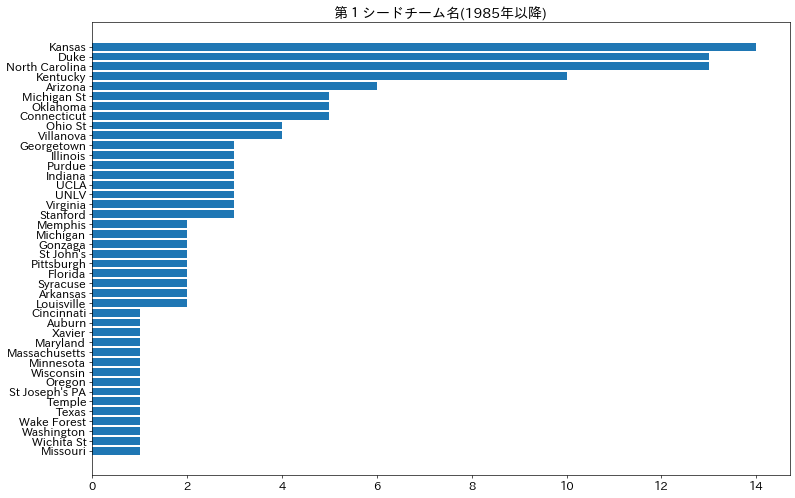

In [111]:
# 1985年以降のNo.1 シードの数
TeamID = 'TeamID'
seed_dummy = pd.merge(left=df_seed, right=df_teams, how='left', on=TeamID)
seed_temp = seed_dummy[seed_dummy['seed_int'] == 1].groupby([TeamID, 'TeamName']).sum().reset_index()[[TeamID, 'TeamName', 'seed_int']].rename(columns={'seed_int': 'number1_seed'}).sort_values('number1_seed')
fig = plt.figure(figsize=(15, 10), dpi=60)
plt.barh(seed_temp['TeamName'], seed_temp['number1_seed'], align='center')
plt.title('第１シードチーム名(1985年以降)')
print(f'第1シードチーム数：{len(seed_temp)}')

1985年以降、毎年68校が出ているNCAA トーナメントで第一シードを取っているチームはたったの42チームしかないことがわかります

In [ ]:
def higher_seed(left:pd.DataFrame, right:pd.DataFrame):
    seed_dummy = pd.merge(left=left, right=right, how='left', on=TeamID, how='left')
    for i in range(1,9):
        tmp_df = seed_dummy[seed_dummy['seed_int'] == i].groupby([TeamID, 'TeamName']).sum().reset_index()[[TeamID, 'TeamName', 'seed_int']].rename(columns={'seed_int': f'seed_{i}_int'})


レギュラーシーズンの勝率も見ていきます

Text(0.5, 1.0, 'レギュラーゲーム勝利数(1985年以降)')

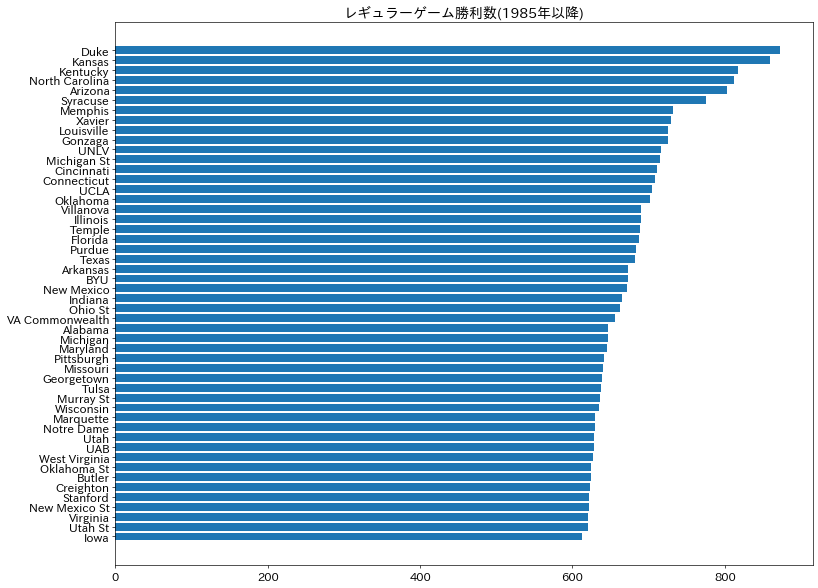

In [119]:
teams_tmp = df_teams.rename(columns={TeamID:'WTeamID'})
reg_game_dummy = pd.merge(left=reg_game_compact, right=teams_tmp, how='left', on='WTeamID').rename(columns={'TeamName':'WTeamName'})
reg_game_tmp = reg_game_dummy.groupby(['WTeamID', 'WTeamName']).count().reset_index()[['WTeamID', 'WTeamName','Season']].rename(columns={'Season':'reg_game_win'}).sort_values('reg_game_win')

# 上位50チームのみ表示します
reg_game_tmp_v1 = reg_game_tmp.iloc[-50:,:]
fig = plt.figure(figsize=(15, 12), dpi=60)
plt.barh(reg_game_tmp_v1['WTeamName'], reg_game_tmp_v1['reg_game_win'], align='center')
plt.title('レギュラーゲーム勝利数(1985年以降)')

In [76]:
df_teams

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
359,1460,Wright St
360,1461,Wyoming
361,1462,Xavier
362,1463,Yale


# 特徴量 `X` の作成

目的変数 `y` が作成できたので次は入力する特徴量 `X` を作っていきます。

特徴量は予測対象に対して紐づくような値 (属性) のことです。機械学習モデルは基本的に数値しか扱えないため、何らかの方法で表現したい情報を数値化する必要があります。\
タイタニックの例で言うと、性別は文字列なため、何らかの方法で性別を表すような数字の表現に直す工程が必要です。また、機械学習ではテキストや画像などを取り扱う場合もありますが、画像であればピクセルの RGB (W x H x 3 の matrix 化) を NLP であれば分かち書き等の手法によって、最終的に数値化されて機械学習へとインプットされています。\
数値への変換は人間の仕事であり、この表現を作っていく工程のことを特徴量エンジニアリング (feature engineering) とよび、機械学習モデルを作成する上で非常に大事な工程となります。

機械学習でハイパーパラメータとは機械学習手法（またはアルゴリズム）の挙動を制御する設定を指します。これらの設定は設計者（エンジニア）が指定

[LightGBM 徹底入門 – LightGBMの使い方や仕組み、XGBoostとの違いについて](https://www.codexa.net/lightgbm-beginner/)

pandasではデータから新しいカラムを作成したり、マージしたりすることはよくあるので、マージするための関数を設定しておきます

pandas では日付系の column に対しては dt 属性以下に便利な propery がいくつかある

特徴量エンジニアリングでは、訓練データ、テストデータどちらにも適用したいので、一旦、最終的に関数にまとめます

[K-分割交差検証とは](https://blog.amedama.jp/entry/2018/08/25/174530)

[LightGBMで交差検証を実装してみるよ](https://potesara-tips.com/lightgbm-k-fold-cross-validation/)
